In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision 
from torchvision import datasets, models, transforms#will have standard data sets
from torch.utils.data import Dataset
import torch.utils.data as data
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy
cudnn.benchmark = True

In [4]:
torch.cuda.device_count()
torch.cuda.get_device_name

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


device(type='cpu')

In [5]:
#data normalisation
data_transform = {
    'train': transforms.Compose([
        #transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [6]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
#splitting the training data into training(80%),validation(20%)
import splitfolders
input_folder ='/content/drive/MyDrive/Data/classification_dataset/train/'
output_folder ='/content/drive/MyDrive/Data/classification_dataset/split'
splitfolders.ratio(input_folder, output = output_folder, seed = 1337, ratio = (0.8, 0.2))

Copying files: 532 files [02:23,  3.72 files/s]


In [9]:
#Loading the training,validation data data
train_data_dir = '/content/drive/MyDrive/Data/classification_dataset/split/'


image_datasets = {x: datasets.ImageFolder(os.path.join(train_data_dir, x), data_transform[x]) for x in ['train', 'val']}

train_dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8, shuffle=True, num_workers=2) for x in ['train', 'val']}

train_dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

print('no.of files available in train,val folders',train_dataset_sizes)
print(class_names)

#loading the test data
test_data_dir = '/content/drive/MyDrive/Data/classification_dataset/'
y='test'
image_datasets = {y: datasets.ImageFolder(os.path.join(test_data_dir,y), data_transform[y])}

test_dataloaders = {y: torch.utils.data.DataLoader(image_datasets[y], batch_size=8, shuffle=True, num_workers=2)}

test_dataset_sizes = {y: len(image_datasets[y])}
test_classes = image_datasets['test'].classes

print('no.of files available in test',test_dataset_sizes)
print(test_classes)





no.of files available in train,val folders {'train': 423, 'val': 109}
['bear', 'butterfly', 'camel', 'chimp', 'duck', 'elephant']
no.of files available in test {'test': 120}
['bear', 'butterfly', 'camel', 'chimp', 'duck', 'elephant']


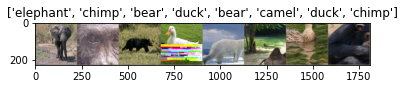

In [10]:
#Training Data visualisation
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in train_dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / train_dataset_sizes[phase]
            epoch_acc = running_corrects.double() / train_dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Model Best validation Accuracy: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [12]:
#testing and visulaising the model predictions
def test_model(model, num_images=6):
    model.eval()
    images_so_far = 0
    testing_corrects=0
    #fig = plt.figure

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            testing_corrects += torch.sum(preds == labels.data)

        for j in range(inputs.size()[0]):
           images_so_far += 1
           ax = plt.subplot(4, 2, images_so_far)
           ax.axis('off')
           ax.set_title(f'predicted: {class_names[preds[j]]}')
           imshow(inputs.cpu().data[j])

                # if images_so_far == num_images:
                #     model.train(mode=was_training)

                #     return
    testing_acc = testing_corrects.double() / test_dataset_sizes['test'] 
    print('Test Accuracy of the model on the 120 test images: {} %'.format(100 * testing_acc))
        

In [14]:
#load the resnet18 model
res18 = models.resnet18(pretrained=True)
print(res18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
#fine tuning
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
for param in model_ft.parameters():
    param.requires_grad = False
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 6)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [16]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.3996 Acc: 0.4681
val Loss: 0.4547 Acc: 0.9174

Epoch 1/24
----------
train Loss: 0.7915 Acc: 0.7352
val Loss: 0.2428 Acc: 0.9725

Epoch 2/24
----------
train Loss: 0.5530 Acc: 0.8440
val Loss: 0.2477 Acc: 0.9358

Epoch 3/24
----------
train Loss: 0.5606 Acc: 0.8038
val Loss: 0.1667 Acc: 0.9450

Epoch 4/24
----------
train Loss: 0.5026 Acc: 0.8227
val Loss: 0.1757 Acc: 0.9541

Epoch 5/24
----------
train Loss: 0.4805 Acc: 0.8392
val Loss: 0.1372 Acc: 0.9725

Epoch 6/24
----------
train Loss: 0.4229 Acc: 0.8582
val Loss: 0.1402 Acc: 0.9725

Epoch 7/24
----------
train Loss: 0.4416 Acc: 0.8487
val Loss: 0.1277 Acc: 0.9725

Epoch 8/24
----------
train Loss: 0.3995 Acc: 0.8605
val Loss: 0.1250 Acc: 0.9725

Epoch 9/24
----------
train Loss: 0.4151 Acc: 0.8700
val Loss: 0.1246 Acc: 0.9725

Epoch 10/24
----------
train Loss: 0.3379 Acc: 0.8794
val Loss: 0.1202 Acc: 0.9725

Epoch 11/24
----------
train Loss: 0.3775 Acc: 0.8700
val Loss: 0.1243 Acc: 0.9725

Ep

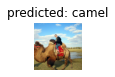

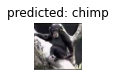

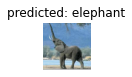

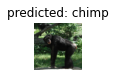

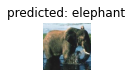

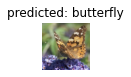

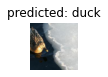

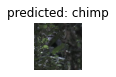

Test Accuracy of the model on the 120 test images: 96.66666666666667 %


In [17]:
test_model(model_ft)